In [1]:
# import packages
import seaborn as sns
import numpy as np
from scipy.io import loadmat
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# define paths
results_dir = "/space/syn50/1/data/ABCD/d9smith/random_effects/behavioral/results/results_20220901/";
outpath = "/home/d9smith/projects/random_effects/behavioral/results/plots/";

In [2]:
params = loadmat(results_dir + 'model_parameters.mat')

In [3]:
fstem_imaging = [item.astype(str).tolist()[0] for item in params['fstem_imaging'][0]]
titles = [item.astype(str).tolist()[0] for item in params['titles'][0]]


In [4]:
# make RandomEffects an array of arrays
RandomEffects = [[char.astype(str).tolist() for char in item] for item in \
                 [item.ravel().tolist() for item in params['RandomEffects'][0]]]

In [5]:
models = pd.DataFrame(fstem_imaging, columns =['shortname'])
models['title'] = titles
models['RandomEffects'] = RandomEffects

In [6]:
models['y2_only'] = [False, False, False, False, True, True, False, False, True, False, \
                     False, False, False, True, True, True, True, True]

In [7]:
baseline_phenos = ["matrix", "pattern", "flanker",  "cardsort", "list", "picture", \
                   "picvocab", "reading", "cryst", "fluidcomp", "totalcomp", "height"]

y2_phenos = ["pattern", "flanker", "picture", "picvocab", "reading", "cryst", "height"]

In [41]:
print([i for i in baseline_phenos])

['matrix', 'pattern', 'flanker', 'cardsort', 'list', 'picture', 'picvocab', 'reading', 'cryst', 'fluidcomp', 'totalcomp', 'height']


In [8]:
# set up paths to results files
results_file = [(results_dir + 'FEMA_wrapper_output_external_' + item + '.json') for item in fstem_imaging]
sig2mat_file = [(results_dir + 'FEMA_wrapper_output_external_' + item + '_sig2mat.json') for item in fstem_imaging]

In [9]:
# define a function for loading results
def load_model(results_file, sig2mat_file, RandomEffects, idx, y2_only = False):
    """
    Loads model and sig2mat from specified results files.
    
    arguments:
    results_file   :  list of .json files where FEMA results are stored -- saved from bg_fema_wrapper.m
    sig2mat_file   :  list of .json files where sig2mat is stored -- saved from bg_fema_wrapper.m
    RandomEffects  :  list of random effects specified for each model
    idx            :  index variable (index is same for each list)
    y2_only        :  indicates whether phenotypes are limited to those collected at year 2
    
    """
    model_file = results_file[idx]
    sig2mat_file = sig2mat_file[idx]
    model = pd.read_json(model_file)
    with open(sig2mat_file) as f:
        sig2mat = json.load(f)
    sig2mat = [pd.DataFrame(s, columns = ['est', 'll', 'ul']) for s in sig2mat]
    for item in sig2mat:
        item['errormin'] = item['est'] - item['ll']
        item['errormax'] = item['ul'] - item['est']
        if y2_only == True:
            item['pheno'] = y2_phenos
        else: 
            item['pheno'] = baseline_phenos      
            
    for i in range(0,len(RandomEffects[idx])):
        sig2mat[i]['param'] = RandomEffects[idx][i][0]
        
    sig2mat = pd.concat(sig2mat)
    
    return model, sig2mat

In [10]:
model = []
sig2mat = []

for i in range(len(models)):
    new_model, new_sig2mat = load_model(results_file, sig2mat_file, RandomEffects, i, models['y2_only'][i])
    model.append(new_model)
    sig2mat.append(new_sig2mat)

In [11]:
# add mx to list of parameters
models.loc[len(models.index)] = ["openmx", "OpenMx ACE Model, twins only at baseline, GRM assumed", \
                                 [['A'], ['F'], ['E']], False] 

In [12]:
# Load OpenMx parameters
mxa_file = results_dir + "openmx_A.csv"
mxc_file = results_dir + "openmx_C.csv"
mxe_file = results_dir + "openmx_E.csv"
mxloglik_file = results_dir + "openmx_loglik.csv"

def load_mx(filename, phenonames, param):
    df = pd.read_csv(filename)
    df.columns = ['pheno', 'est', 'll', 'ul']
    df['errormin'] = df['est'] - df['ll']
    df['errormax'] = df['ul'] - df['est']
    df['pheno'] = phenonames
    df['param'] = param
    return df

mxa = load_mx(mxa_file, baseline_phenos, 'A')
mxc = load_mx(mxc_file, baseline_phenos, 'F')
mxe = load_mx(mxe_file, baseline_phenos, 'E')
mxloglik = pd.read_csv(mxloglik_file)

openmx = pd.concat([mxa, mxc, mxe])
sig2mat.append(openmx)

model.append(mxloglik.rename(columns={"openmx_loglik": "logLikvec"}))

In [13]:
models['name'] = ['Model ' + str(i+1) for i in range(len(models))]
# models[models['shortname'] == 'openmx']['name'] = 'Model 1'

models.at[(models.index[models['shortname'] == 'openmx'].tolist()[0]),'name']='Model 1'



In [14]:
models

,shortname,title,RandomEffects,y2_only,name
0,model1,"FEMA ACE Model, twins only at baseline, assign...","[[A], [F], [E]]",False,Model 1
1,model2,"ACE Model, twins only at baseline, measured GRM","[[A], [F], [E]]",False,Model 2
2,model3,"ACE Model, full sample at baseline, measured GRM","[[A], [F], [E]]",False,Model 3
3,model4,"ACTE Model, full sample at baseline, measured GRM","[[A], [F], [T], [E]]",False,Model 4
4,model5,"ACTE Model, full sample at baseline and year 2...","[[A], [F], [T], [E]]",True,Model 5
5,model6,"ACTSE Model, full sample at baseline and year ...","[[A], [F], [T], [S], [E]]",True,Model 6
6,s1_assigngrm_m3,"ACE Model, full sample at baseline, assigned GRM","[[A], [F], [E]]",False,Model 7
7,s1_assigngrm_m4,"ACTE Model, full sample at baseline, assigned GRM","[[A], [F], [T], [E]]",False,Model 8
8,s1_assigngrm_m5,"ACTSE Model, full sample at baseline and year ...","[[A], [F], [T], [S], [E]]",True,Model 9
9,s2_allcovs_m1,"ACE Model, twins only at baseline, assigned GR...","[[A], [F], [E]]",False,Model 10


In [15]:
def my_colors(RandomEffects):
    """
    Takes a list of random effects and returns colors in the correct order.

    """
    
    labels = np.array(RandomEffects)
    dict = {'A':'#1f77b4','C':'#ff7f0e','F':'#ff7f0e','T':'#d62728','S':'#9467bd','E':'#2ca02c'}
    colors = [dict[lbl] for lbl in RandomEffects]
    return colors

print(my_colors('T')[0])


#d62728


<AxesSubplot:title={'center':'Model 1 vs Model 1'}, xlabel='Model 1: FEMA ACE Model, twins only at baseline, assigned GRM', ylabel='Model 1: OpenMx ACE Model, twins only at baseline, GRM assumed'>

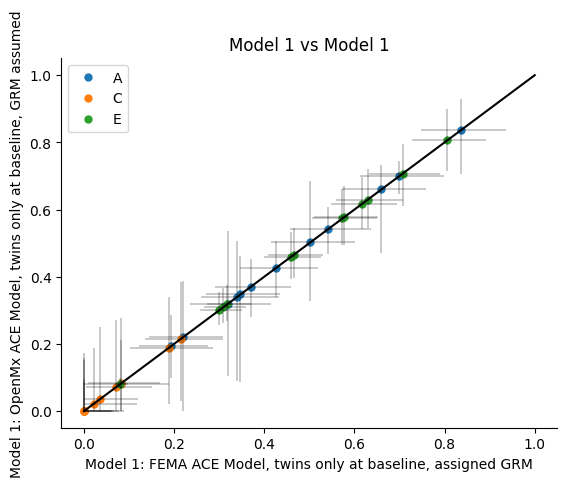

In [16]:
# function to compare two models
def compare_models(name1, name2, sig2mat, models, ax = None, lbl = None):
    """
    Visualize FEMA random effects estimates with confidence intervals.
    
    arguments:
    model1          :    string with title of model to plot on x axis
    model2          :    string with title of model to plot on y axis
    sig2mat         :    list of sig2mat matrices with random effects estimates
    models          :    dataframe of model parameters
    lbl             :    optional argument to supply minimum difference to label (if number)
    
    """
    i = models.index[models['shortname'] == name1].tolist()[0]
    j = models.index[models['shortname'] == name2].tolist()[0]
    
    model1 = sig2mat[i]
    model2 = sig2mat[j]
    
    title1 = models['title'][i]
    title2 = models['title'][j]
    
    modnum1 = models['name'][i]
    modnum2 = models['name'][j]

    tmp = model1.merge(model2, on = ['pheno', 'param'], suffixes = ['_model1', '_model2'])
    
    tmp['param'] = tmp['param'].replace('F','C')
#     print(tmp[tmp['param']=='A'])
    ax = ax or plt.gca()

    groups = tmp.groupby('param')
    for name, group in groups:
        ax.plot(group.est_model1, group.est_model2, marker='o', linestyle='', 
                markersize=5, label=name, color = my_colors(name)[0])
        
       
    #get handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    #specify order of items in legend    
    if len(labels) == 3:
        order = [0,1,2]
    elif len(labels) == 4:
        order = [0,1,3,2]
    elif len(labels) == 5:
        order = [0,1,4,3,2]

    #add legend to plot
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 
    
    # creating error
    x_errormin = tmp['errormin_model1']
    x_errormax = tmp['errormax_model1']

    y_errormin = tmp['errormin_model2']
    y_errormax = tmp['errormax_model2']

    x_error = [x_errormin, x_errormax]
    y_error = [y_errormin, y_errormax]

    ax.errorbar(tmp['est_model1'], tmp['est_model2'],
                 yerr=y_error,
                 xerr=x_error,
                 fmt='none',
                ecolor = 'black',
                elinewidth = 0.3)  

    ax.set_title(modnum1 + ' vs ' + modnum2)
    # Set x-axis label
    ax.set_xlabel(modnum1 + ': ' + models['title'][i])
    # Set y-axis label
    ax.set_ylabel(modnum2 + ': ' + models['title'][j])
    
    # add line at model 1 = model 2
    ax.plot([0, 1], [0, 1], 'k-')
    
    # add labels
    tmp['diff'] = tmp['est_model1'] - tmp['est_model2']

    if(lbl):
        
        if type(lbl) == float:

            labels = tmp[abs(tmp['diff']) > lbl]
            label_x = labels['est_model1'].tolist()
            label_y = labels['est_model2'].tolist()
            labels_txt = labels['pheno'].tolist()
            x_offset = (5 * labels['diff']/abs(labels['diff'])).tolist()
            align = ['left' if item > 0 else 'right' for item in labels['diff'].tolist()]



        elif type(lbl) == list:
            label_x, label_y, labels_txt, x_offset, align = [[],[],[],[],[]]
            for pheno, param in lbl:
                labels_txt.append(pheno)
                label_x.append(tmp[(tmp['param'] == param) & (tmp['pheno'] == pheno)]['est_model1'].squeeze())
                label_y.append(tmp[(tmp['param'] == param) & (tmp['pheno'] == pheno)]['est_model2'].squeeze())
                diff = tmp[(tmp['param'] == param) & (tmp['pheno'] == pheno)]['diff'].squeeze()
                
                x_offset.append(5 * diff/abs(diff))
                align.append('left' if diff > 0 else 'right')
                
        for i, txt in enumerate(labels_txt):
            ax.annotate(txt, (label_x[i], label_y[i]), textcoords="offset points", # how to position the text
                     xytext=(x_offset[i],5), # distance from text to points (x,y)
                     ha=align[i]) # horizontal alignment can be left, right or center)
            
    sns.despine()

#     plt.show()
    return ax

# for debugging
compare_models("model1", "openmx", sig2mat, models)

In [17]:
# create function to write stacked bar graph for each model
def stacked_bar(model_name, sig2mat_list, models, ax = None, label=0.04):
    """
    Plots a stacked bar chart of random effects estimates for a given model.
    
    Args:
      model_name : string that corresponds to name of model
      sig2mat_list : list of sig2mat matrices of random effects
      models : dataframe of model parameters
      label : threshold for labeling bars
      
    """
    i = models.index[models['shortname'] == model_name].tolist()[0]
    
    df = pd.pivot_table(sig2mat_list[i][['est', 'pheno', 'param']], values='est', index=['pheno'], columns=['param'], sort=False)
    
    fields = [j[0] for j in models['RandomEffects'][i]]
    labels = ['C' if item == 'F' else item for item in fields]
    print()
        #specify order of items in legend    
    if len(labels) == 3:
        order = [0,1,2]
    elif len(labels) == 4:
        order = [0,1,3,2]
    else:
        order = [0,1,3,4,2]
    
    ax = ax or plt.gca()

    # figure and axis
#     fig, ax = plt.subplots(1, figsize=(9, 7.5))

    # plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        ax.barh(df.index, df[name], left = left, color = my_colors(name)[0])
        left = left + df[name]
    
    # title, legend, labels
    ax.set_title(models['name'][i] + ': ' + models['title'][i] + '\n', loc='left')
    ax.set_xlabel('Proportion of Variance')

    #add legend to plot
    ax.legend(labels, loc = 'lower left', bbox_to_anchor=([-0.02, 0.98]), ncol=5, frameon=False) 
    
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    
    # add data labels
    for c in ax.containers:
        labels = ["{:.2f}".format(v.get_width()) if v.get_width() >= label else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center')  
        
    sns.set_context("paper")
       
#     plt.show()
    return ax

# for debugging
# stacked_bar("s3_notwins", sig2mat, models, label = 0.05)


In [18]:
# function to plot difference in AIC between two models
def plot_aic(name1, name2, model, models, phenonames, ax = None, label = None, sig2tvec = False):
#     """
#     Visualize difference in AIC (computed as -2(delta LL) + 2(delta k).
#     If model 1 performs better than model 2, delta_aic < 0
#     If model 2 performs better than model 1, delta_aic > 0
    
#     arguments:
#     name1          :    string with title of model to plot on x axis
#     name2          :    string with title of model to plot on y axis
#     model          :    dataframe of model results
#     models         :    dataframe of model parameters
#     phenonames     :    list of phenotypes (usually baseline_phenos or y2_phenos)
#     sig2tvec       :    optional - will cause plot to show change in sig2tvec instead
    
#     """

    i = models.index[models['shortname'] == name1].tolist()[0]
    j = models.index[models['shortname'] == name2].tolist()[0]

    model1 = model[i]
    model2 = model[j]

    # since all models are pre-residualized, k is equal to the number of random effects
    k = [len(row) for row in models['RandomEffects']]

    delta_aic = -2 * (model1['logLikvec']-model2['logLikvec']) + 2 * (k[i]-k[j])
#     print(delta_aic)
    ax = ax or plt.gca()

#     if (sig2tvec):
#         ax.barh(phenonames, delta_sig2tvec, color = "#c0d6e4")
#         ax.set_xlabel("Percent change in total residual (" + models['name'][i] + " - " + models['name'][j] + ")");
#     else:
#         ax.barh(phenonames, delta_aic, color = "#849DAB")
#         ax.set_xlabel("Delta AIC (negative values favor " + models['name'][i] + ")");

    if (sig2tvec):
        delta_sig2tvec = (model1['sig2tvec'] - model2['sig2tvec']) / model2['sig2tvec']
        ax.barh(phenonames, delta_aic, label="Delta AIC", 
            color = "#849DAB", height = 0.4, align = 'edge')
        ax.set_xlabel("Delta AIC (negative values favor " + models['name'][i] + ")")
        
        if label:
            plt.axvline(x=label, color = 'k', ls=':')
        
        ax2 = ax.twiny()
        ax2.barh(phenonames, delta_sig2tvec, label='Residual', 
                 color = "#c0d6e4", height = -0.4, align = 'edge')
        ax2.set_xlabel('Percent change in residual')

        leg = ax.legend()
        leg2 = ax2.legend()

        plt.legend(leg.get_patches()+leg2.get_patches(), 
                   [text.get_text() for text in leg.get_texts()+leg2.get_texts()])
        leg.remove()
        
    else:            
        ax.barh(phenonames, delta_aic, color = "#849DAB")
        ax.set_xlabel("Delta AIC (negative values favor " + models['name'][i] + ")");
        
        if label:
            plt.axvline(x=label, color = 'k', ls=':')

    # add line at delta AIC = 2
    # ax.plot([2, 0], [2, 8], 'k-')
    
    plt.axvline(x=0, color = 'k', ls = '-', lw = 0.5)
    

        
    sns.set_context("paper")
    sns.despine()
    
    return ax

# plot_aic("model6", "s1_assigngrm_m5", model, models, y2_phenos, label =-2)


# 1. “Classic” ACE Model

For some reason the Matrix Reasoning phenotype (pea_wiscv_trs) is yielding slightly different estimates for A and C.


<AxesSubplot:title={'left':'Model 1: FEMA ACE Model, twins only at baseline, assigned GRM\n'}, xlabel='Proportion of Variance'>

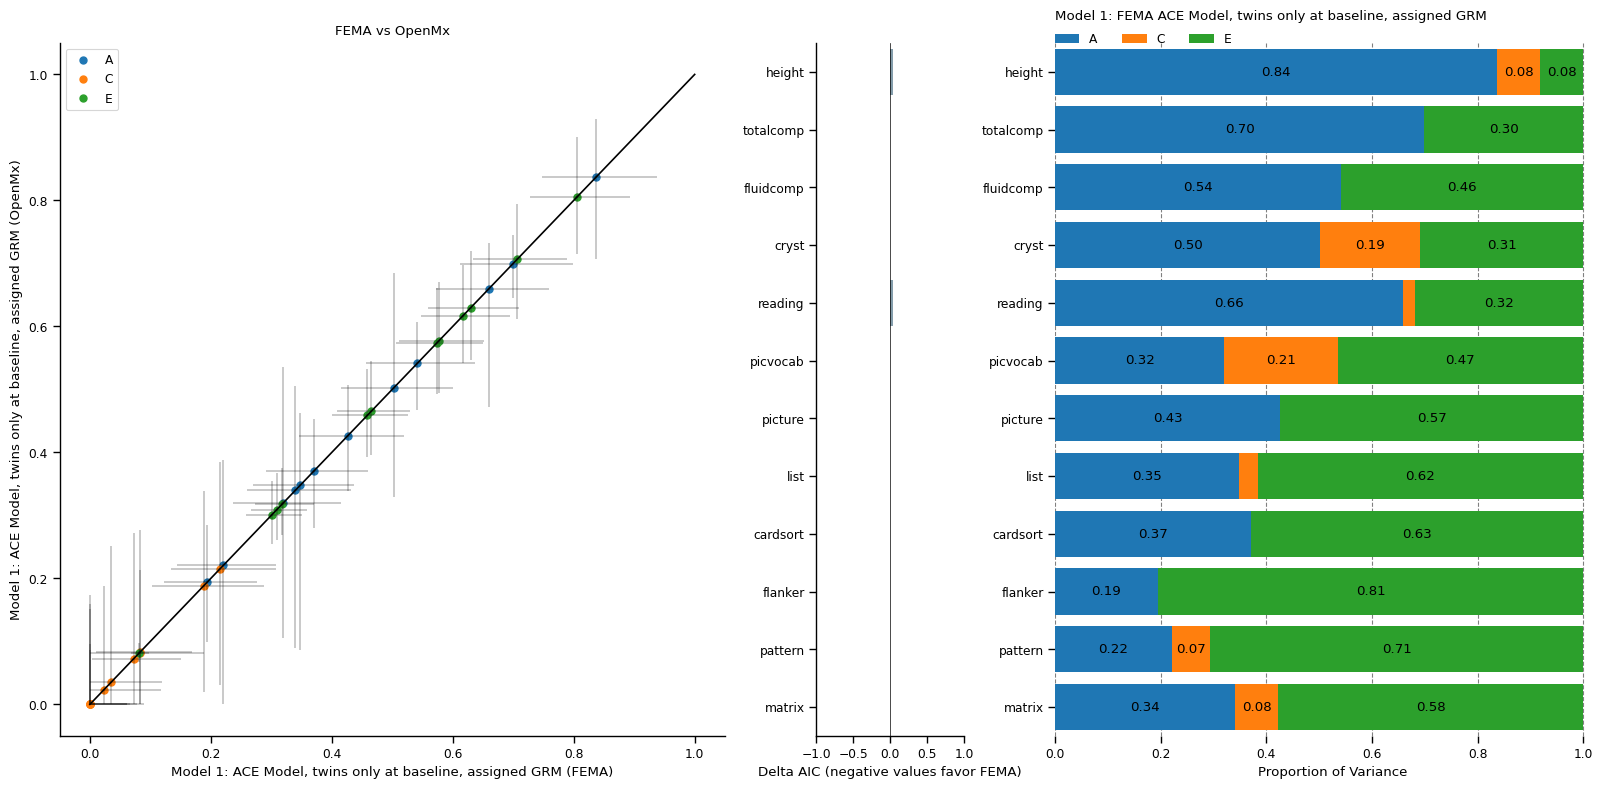

In [46]:
# Setting up the plot surface
fig = plt.figure(figsize=(20, 9))
gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5])

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("model1", "openmx", sig2mat, models, ax=ax0, lbl = 0.05)
ax0.set_title("FEMA vs OpenMx")
ax0.set_xlabel("Model 1: ACE Model, twins only at baseline, assigned GRM (FEMA)")
ax0.set_ylabel("Model 1: ACE Model, twins only at baseline, assigned GRM (OpenMx)")

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("model1", "openmx", model, models, baseline_phenos)
ax1.set_xlabel("Delta AIC (negative values favor FEMA)")
ax1.set_xlim(-1,1)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("model1", sig2mat, models, ax=ax2)


# 2. Effect of including measured GRM

<AxesSubplot:title={'left':'Model 2: ACE Model, twins only at baseline, measured GRM\n'}, xlabel='Proportion of Variance'>

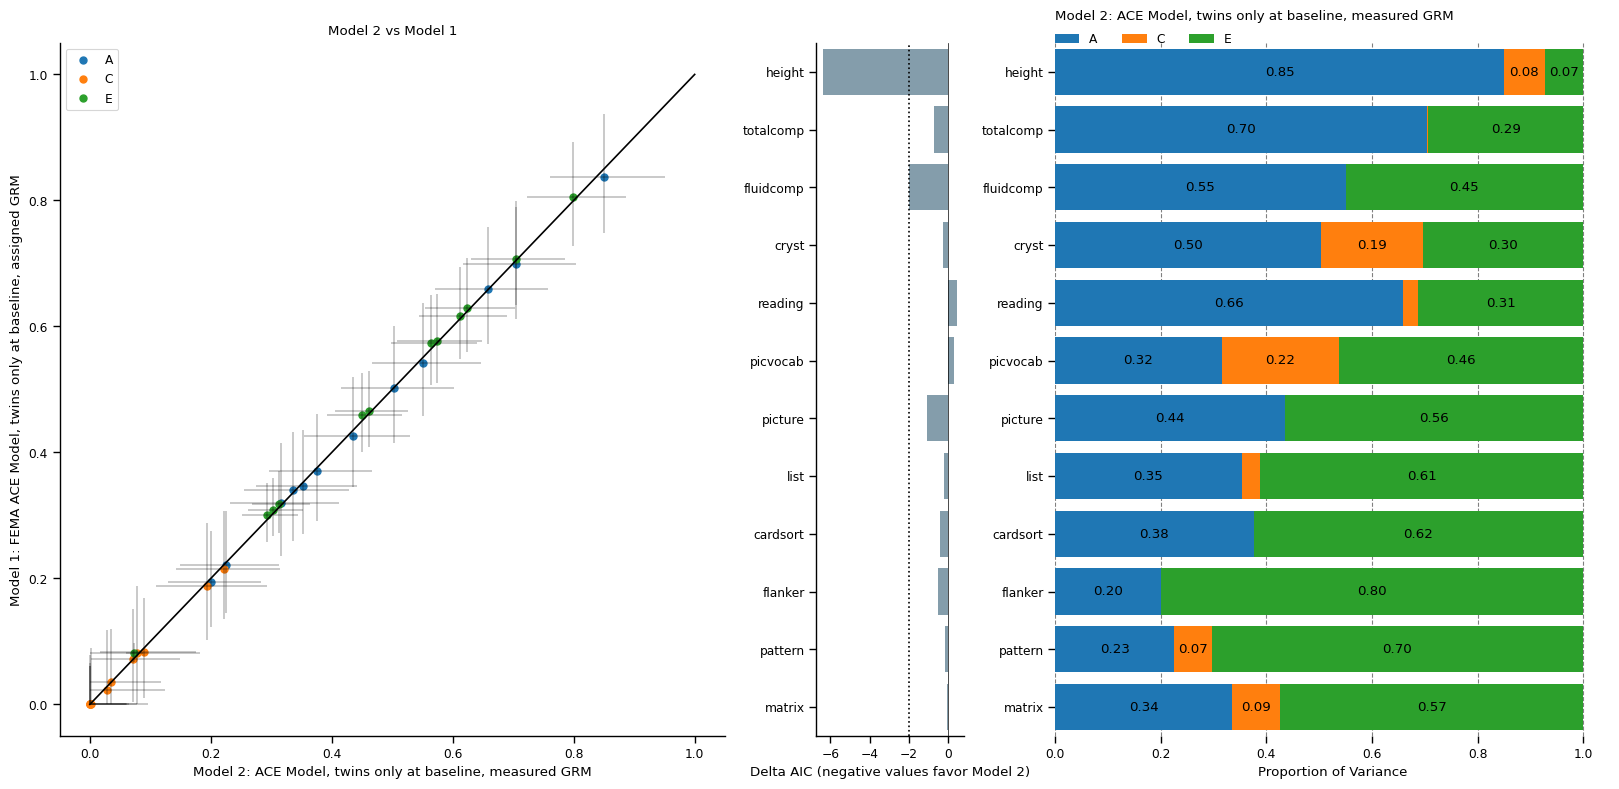

In [47]:
# Setting up the plot surface
fig = plt.figure(figsize=(20, 9))
gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5])

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("model2", "model1", sig2mat, models, ax=ax0)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("model2", "model1", model, models, baseline_phenos, label =-2)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("model2", sig2mat, models, ax=ax2)

# 3. Effect of using GRM in full sample, baseline only

<AxesSubplot:title={'left':'Model 3: ACE Model, full sample at baseline, measured GRM\n'}, xlabel='Proportion of Variance'>

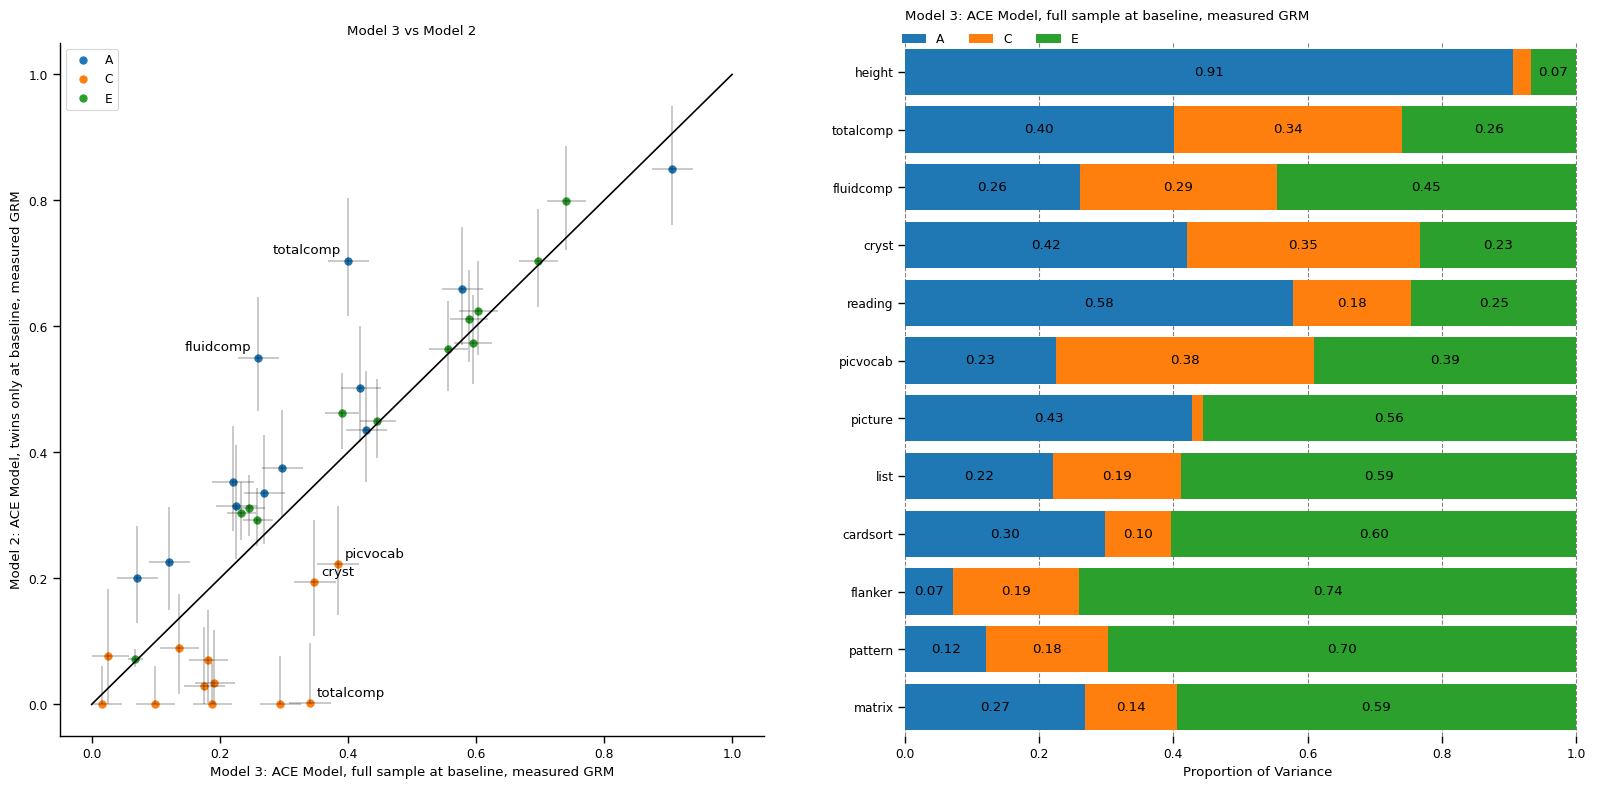

In [49]:
# Setting up the plot surface
fig = plt.figure(figsize=(20,9))
gs = GridSpec(nrows=1, ncols=2)

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("model3", "model2", sig2mat, models, ax=ax0, lbl = [("totalcomp", "A"), ("fluidcomp", "A"),
                                                           ("totalcomp", "C"), ("picvocab", "C"), ("cryst", "C")])

# compare_models("model3", "model2", sig2mat, models, ax=ax0, lbl = .1)

# skipping AIC because different samples

# Right axes
ax2=fig.add_subplot(gs[0, 1])
stacked_bar("model3", sig2mat, models, ax=ax2)

# 4. What is the importance of the Twin effect (T)?

<AxesSubplot:title={'left':'Model 4: ACTE Model, full sample at baseline, measured GRM\n'}, xlabel='Proportion of Variance'>

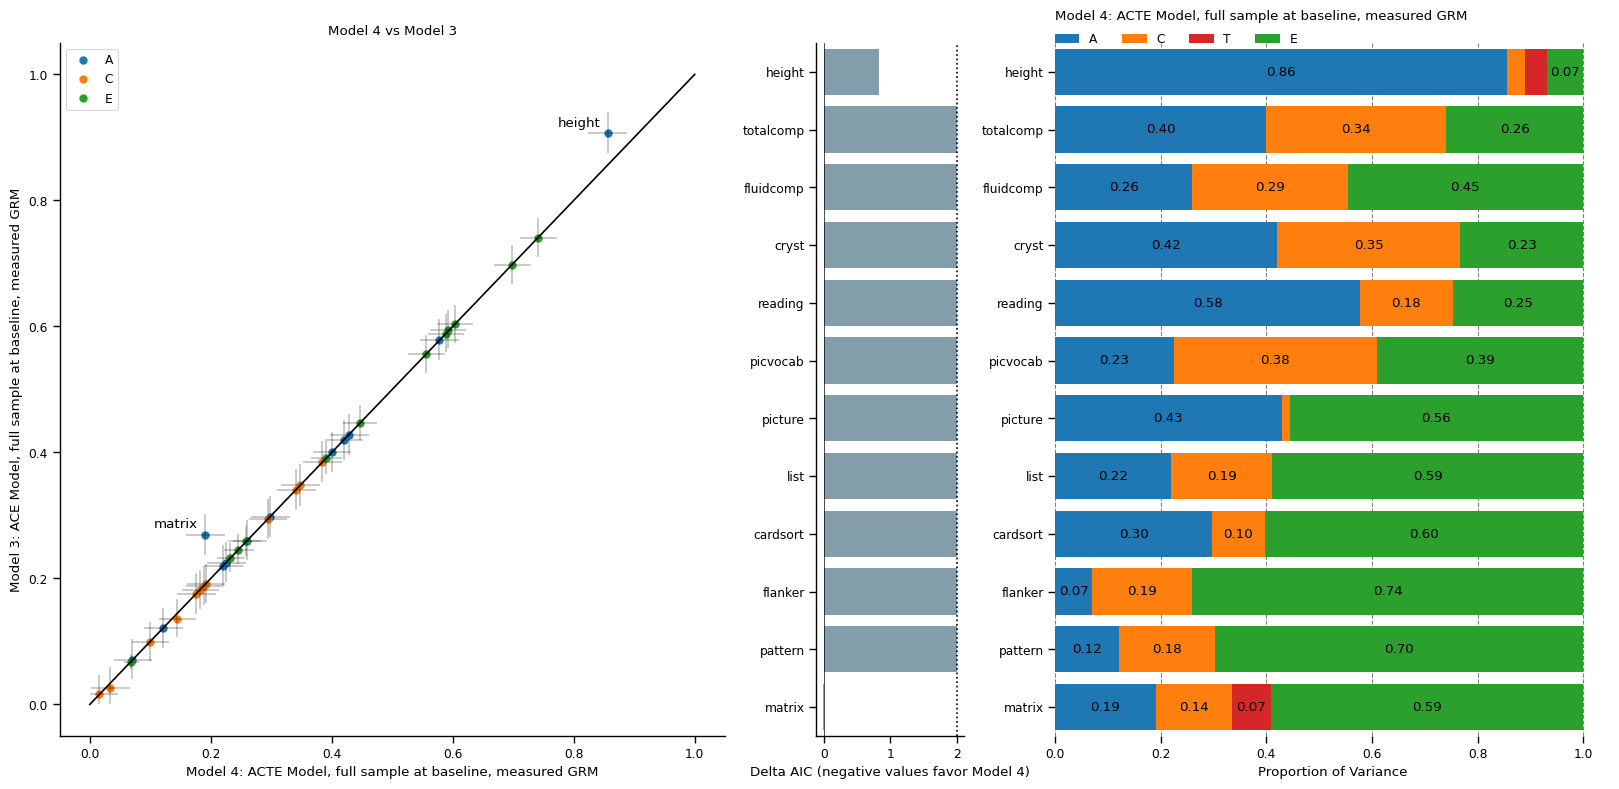

In [22]:
# Setting up the plot surface
fig = plt.figure(figsize=(20, 9))
gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5])

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("model4", "model3", sig2mat, models, ax=ax0, lbl = 0.05)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("model4", "model3", model, models, baseline_phenos, label =2)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("model4", sig2mat, models, ax=ax2, label=.05)

# 5. Effect of including subject-specific variance over time:

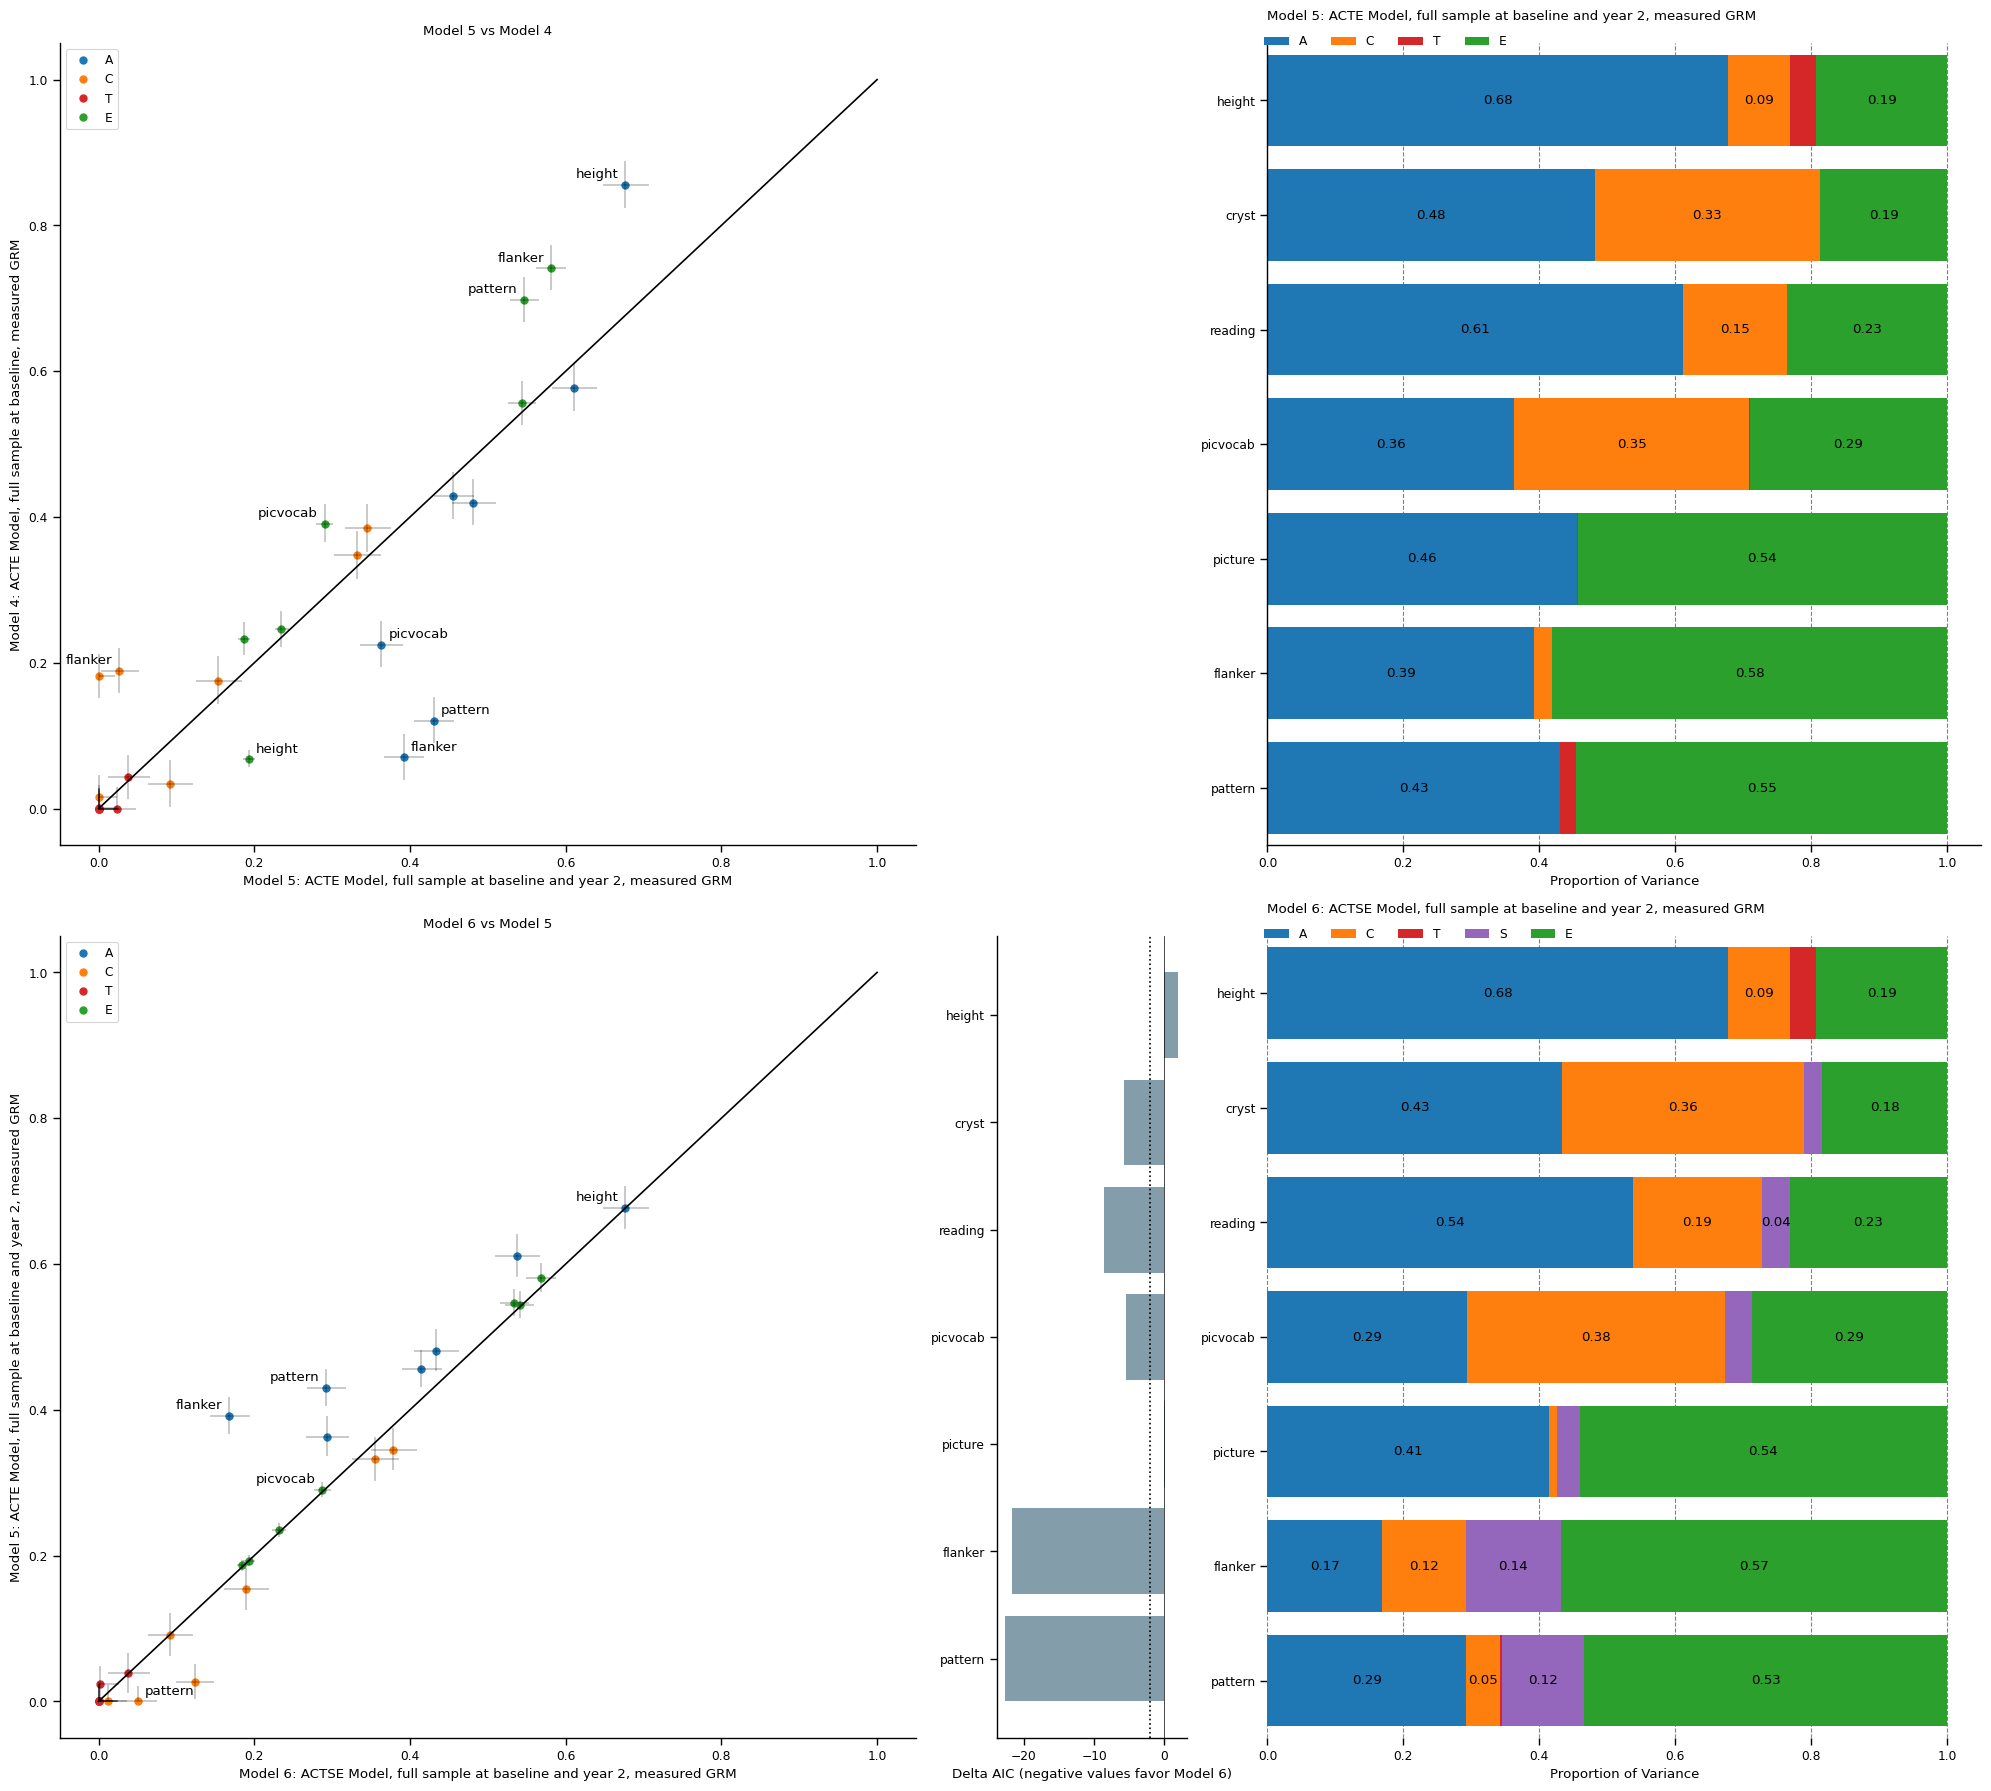

In [59]:
# compare_models("model5", "model4", sig2mat, models)

# stacked_bar("model5", sig2mat, models)

# Setting up the plot surface
fig = plt.figure(figsize=(20,18))
gs = GridSpec(nrows=2, ncols=3, width_ratios = [9,2,7.5])

## Model 5 vs Model 4

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("model5", "model4", sig2mat, models, ax=ax0, lbl = [("height", "A"),("pattern", "A"), 
                                                                   ("flanker", "A"),("picvocab", "A"),
                                                                   ("flanker", "C"),("flanker", "E"),
                                                                   ("pattern", "E"),("height","E"),
                                                                   ("picvocab", "E")])

# skipping AIC because samples are different
# Right axes
ax2=fig.add_subplot(gs[0, 2])
stacked_bar("model5", sig2mat, models, ax=ax2)
fig.tight_layout()

## Model 6 vs Model 5
# Left axes
ax0 = fig.add_subplot(gs[1, 0])
compare_models("model6", "model5", sig2mat, models, ax=ax0, lbl = [("height", "A"),("pattern", "A"), 
                                                                   ("pattern", "C"),("flanker", "A"),
                                                                   ("picvocab", "E")])
# compare_models("model6", "model5", sig2mat, models, ax=ax0, lbl = 0.1)


# Middle axes
ax1=fig.add_subplot(gs[1,1])
plot_aic("model6", "model5", model, models, y2_phenos, ax=ax1, label =-2)

# Right axes
ax2=fig.add_subplot(gs[1, 2])
stacked_bar("model6", sig2mat, models, ax=ax2)
fig.tight_layout()

# What if we didn't have GRM?

<AxesSubplot:title={'left':'Model 9: ACTSE Model, full sample at baseline and year 2, assigned GRM\n'}, xlabel='Proportion of Variance'>

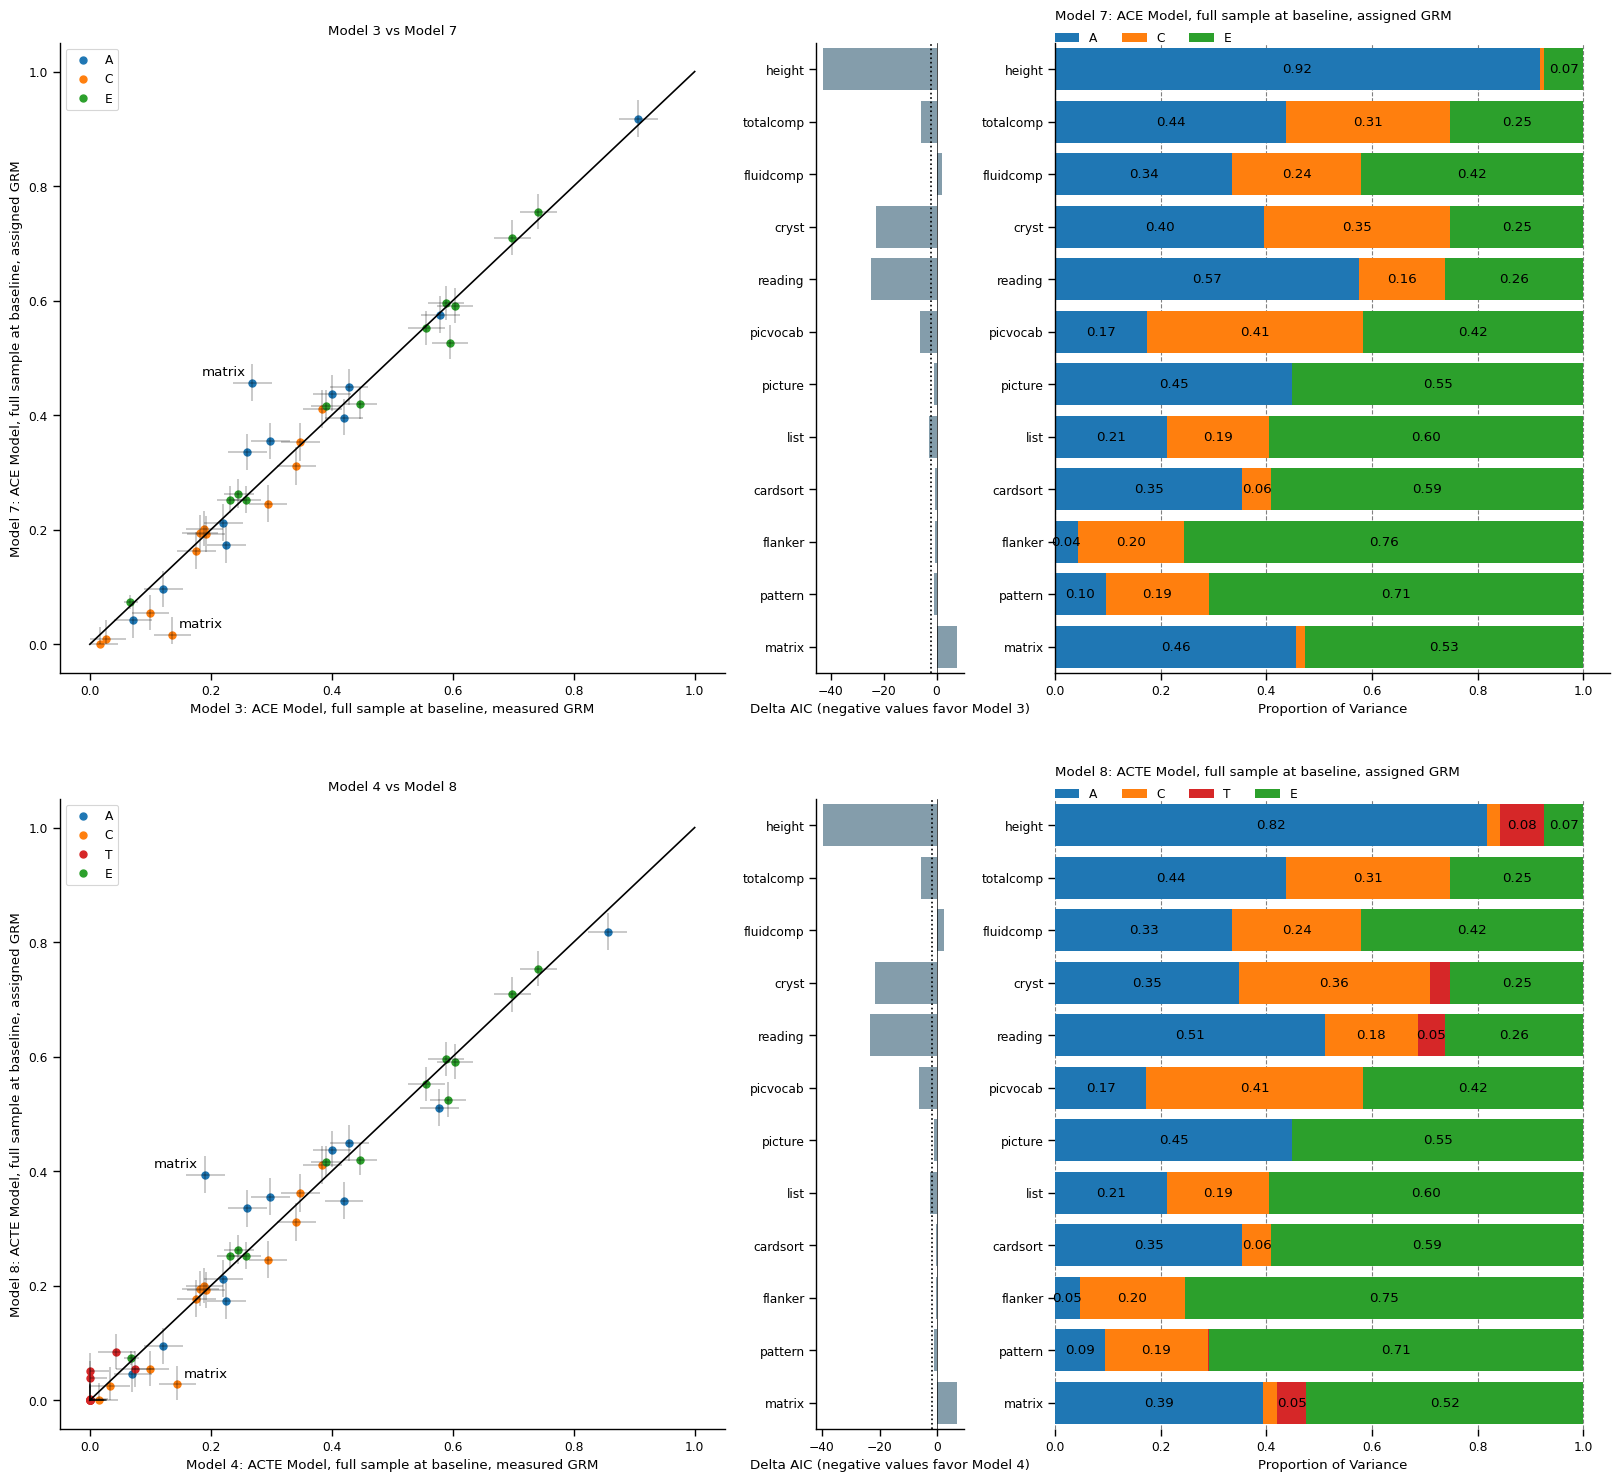

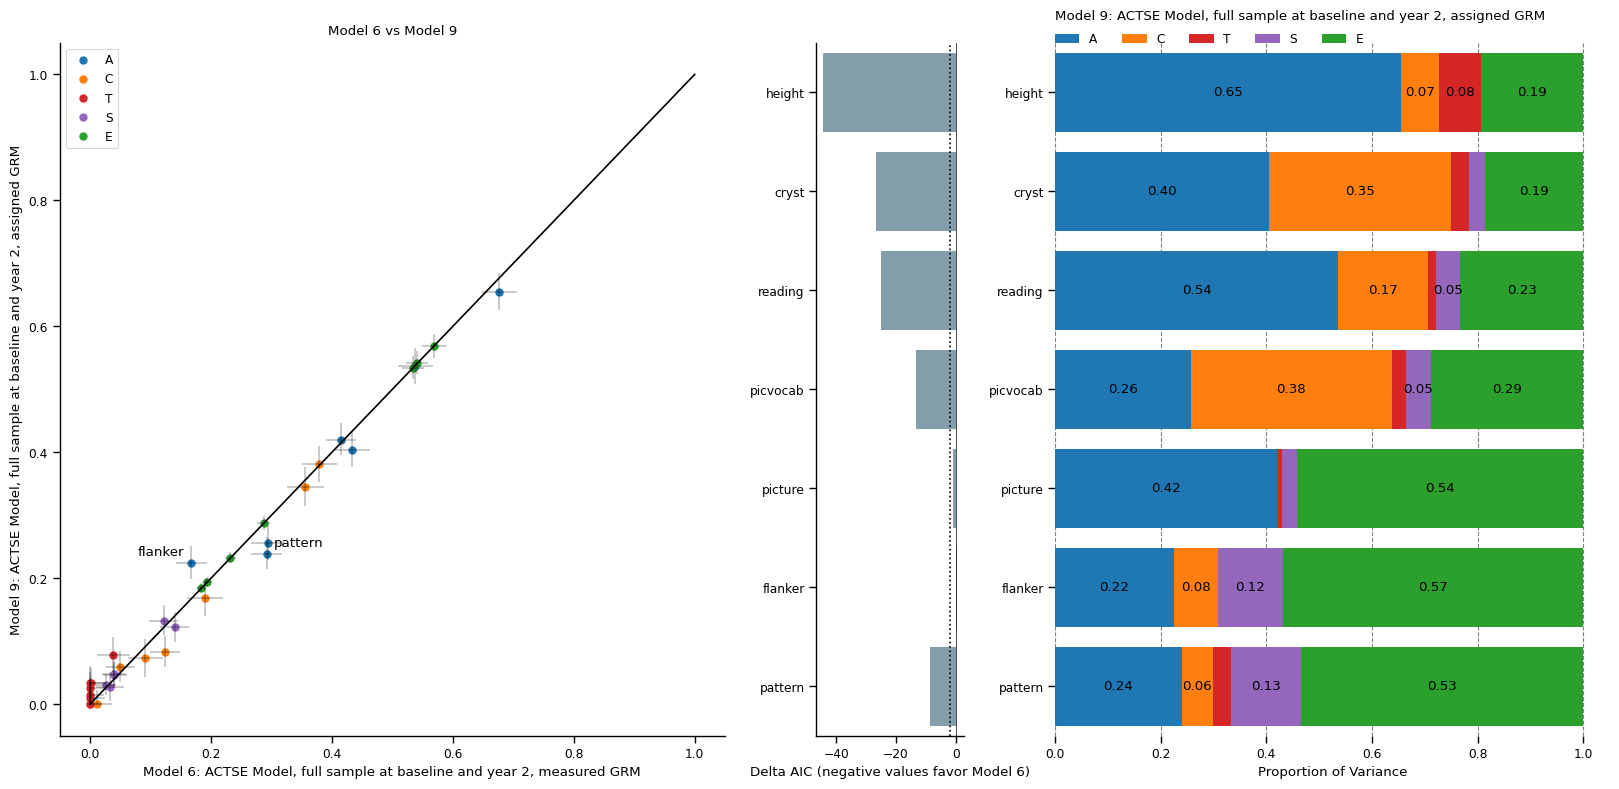

In [60]:
# compare_models("model5", "s1_assigngrm_m5", sig2mat, models)

# stacked_bar("s1_assigngrm_m5", sig2mat, models)

## MODEL 3 WITH ASSIGNED GRM

# Setting up the plot surface
fig = plt.figure(figsize=(20, 18))
gs = GridSpec(nrows=2, ncols=3, width_ratios = [9,2,7.5])

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("model3", "s1_assigngrm_m3", sig2mat, models, ax=ax0, lbl = .1)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("model3", "s1_assigngrm_m3", model, models, baseline_phenos, label =-2)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("s1_assigngrm_m3", sig2mat, models, ax=ax2)

## MODEL 4 WITH ASSIGNED GRM

# # Setting up the plot surface
# fig = plt.figure(figsize=(20, 9))
# gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5])

# Left axes
ax0 = fig.add_subplot(gs[1, 0])
compare_models("model4", "s1_assigngrm_m4", sig2mat, models, ax=ax0, lbl = .1)

# Middle axes
ax1=fig.add_subplot(gs[1,1])
plot_aic("model4", "s1_assigngrm_m4", model, models, baseline_phenos, label =-2)

# Right axes
ax2=fig.add_subplot(gs[1, 2], sharey=ax1)
stacked_bar("s1_assigngrm_m4", sig2mat, models, ax=ax2)

## MODEL 5 WITH ASSIGNED GRM

# Setting up the plot surface
fig = plt.figure(figsize=(20, 9))
gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5])

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("model6", "s1_assigngrm_m5", sig2mat, models, ax=ax0, lbl = .05)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("model6", "s1_assigngrm_m5", model, models, y2_phenos, label =-2)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("s1_assigngrm_m5", sig2mat, models, ax=ax2)

# Side question 2: covariates

<AxesSubplot:title={'left':'Model 10: ACE Model, twins only at baseline, assigned GRM, residualized for covariates\n'}, xlabel='Proportion of Variance'>

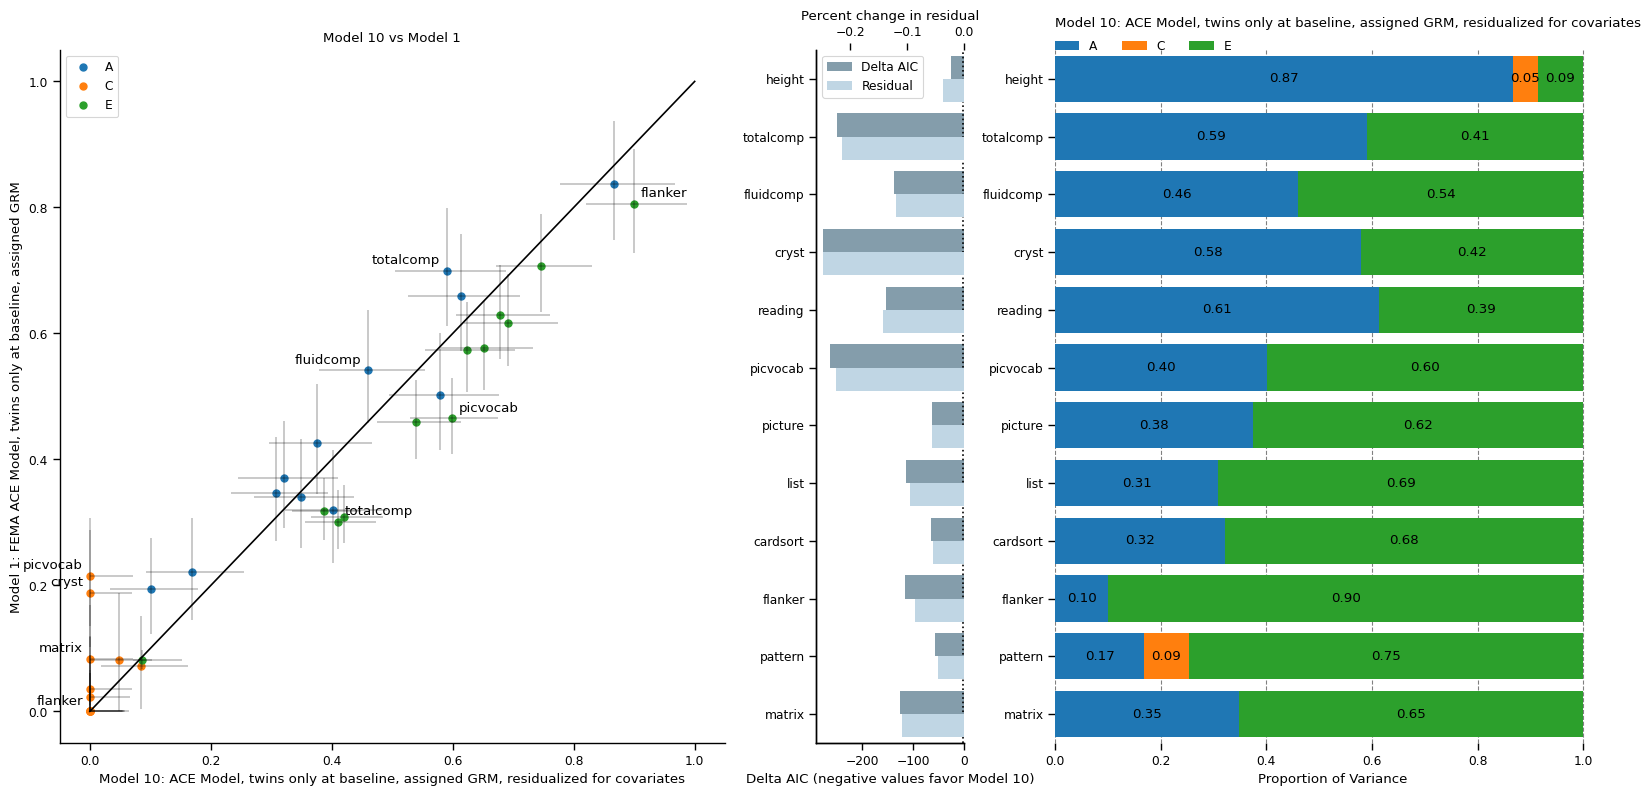

In [67]:
## MODEL 1

# Setting up the plot surface
fig = plt.figure(figsize=(20, 9))
gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5])

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("s2_allcovs_m1", "model1", sig2mat, models, ax=ax0, lbl = [("totalcomp", "A"),("fluidcomp", "A"), 
                                                                          ("picvocab", "C"),("flanker", "C"),
                                                                          ("cryst", "C"),("matrix", "C"),
                                                                          ("totalcomp", "E"),("flanker", "E"),
                                                                          ("picvocab", "E")])

# compare_models("s2_allcovs_m1", "model1", sig2mat, models, ax=ax0, lbl = .08)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("s2_allcovs_m1", "model1", model, models, baseline_phenos, label =-2, sig2tvec = True)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("s2_allcovs_m1", sig2mat, models, ax=ax2)

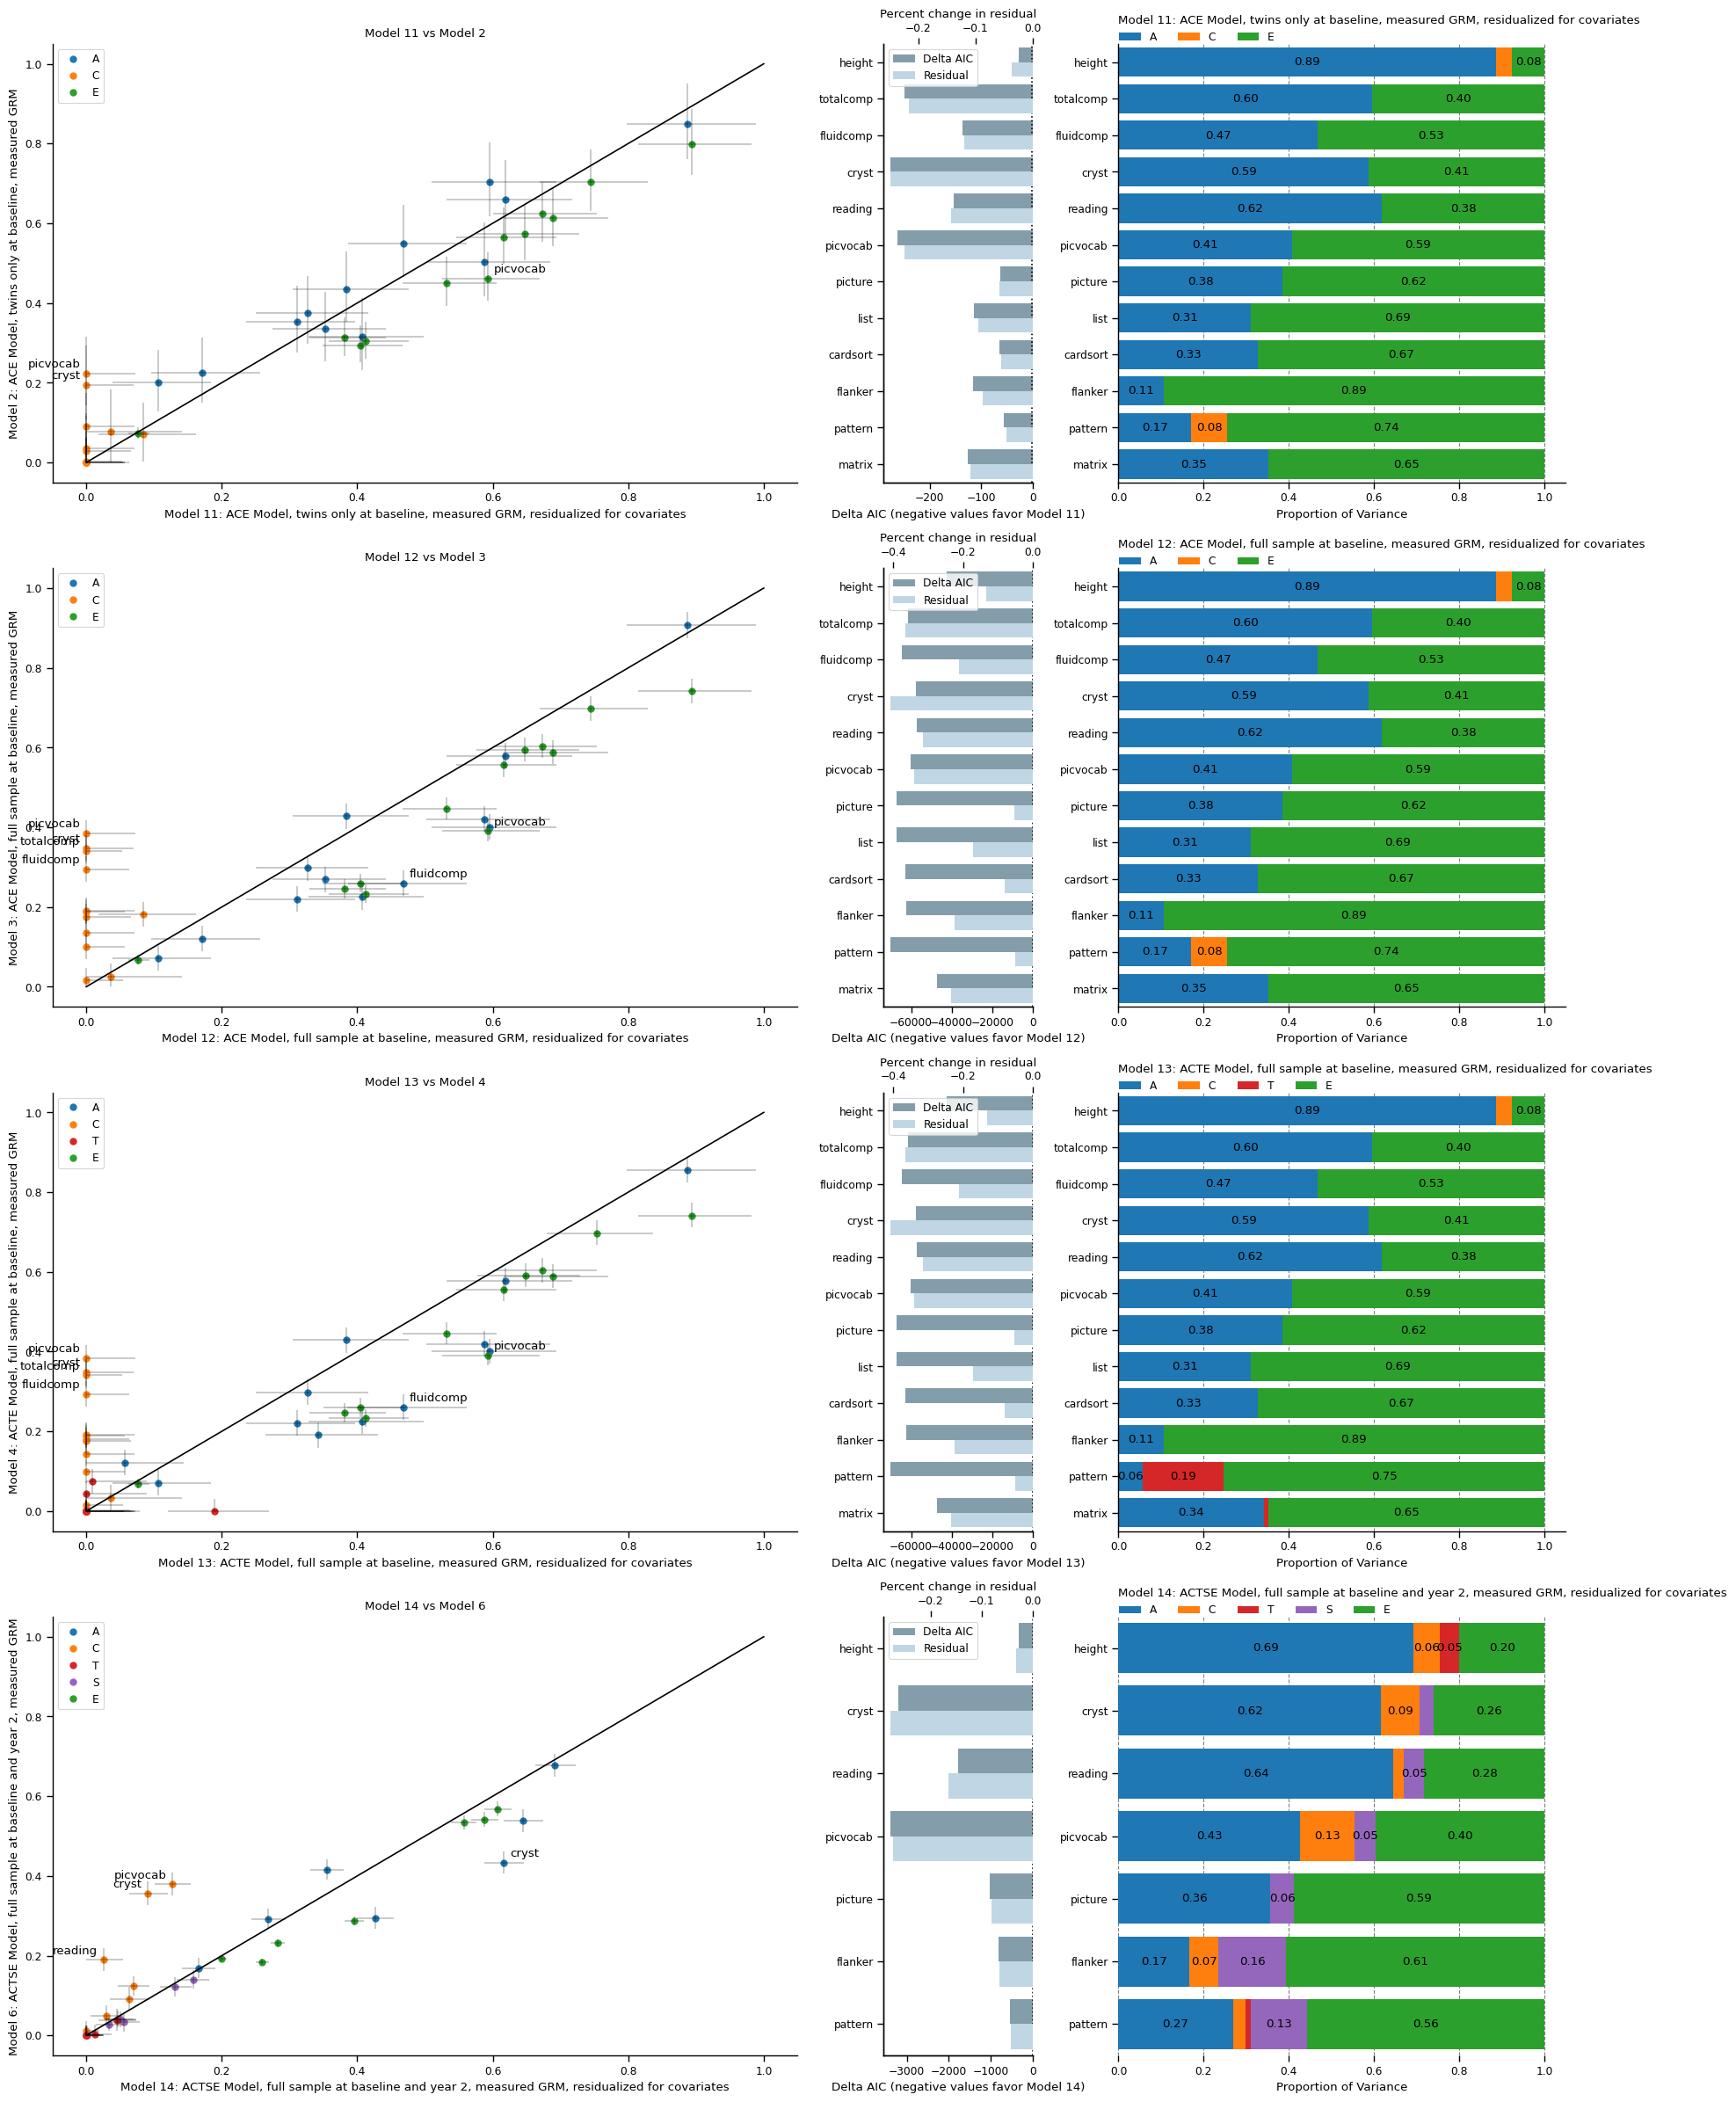

In [26]:
# Setting up the plot surface
fig = plt.figure(figsize=(18, 24))
gs = GridSpec(nrows=4, ncols=3, width_ratios = [10,2,6])

## MODEL 2

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("s2_allcovs_m2", "model2", sig2mat, models, ax=ax0, lbl = .12)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("s2_allcovs_m2", "model2", model, models, baseline_phenos, label =-2, sig2tvec = True)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("s2_allcovs_m2", sig2mat, models, ax=ax2)

## MODEL 3

# Left axes
ax0 = fig.add_subplot(gs[1, 0])
compare_models("s2_allcovs_m3", "model3", sig2mat, models, ax=ax0, lbl = .2)

# Middle axes
ax1=fig.add_subplot(gs[1,1])
plot_aic("s2_allcovs_m3", "model3", model, models, baseline_phenos, label =-2, sig2tvec = True)

# Right axes
ax2=fig.add_subplot(gs[1, 2], sharey=ax1)
stacked_bar("s2_allcovs_m3", sig2mat, models, ax=ax2)

## MODEL 4

# Left axes
ax0 = fig.add_subplot(gs[2, 0])
compare_models("s2_allcovs_m4", "model4", sig2mat, models, ax=ax0, lbl = .2)

# Middle axes
ax1=fig.add_subplot(gs[2,1])
plot_aic("s2_allcovs_m4", "model4", model, models, baseline_phenos, label =-2, sig2tvec = True)

# Right axes
ax2=fig.add_subplot(gs[2, 2], sharey=ax1)
stacked_bar("s2_allcovs_m4", sig2mat, models, ax=ax2)

## MODEL 5

# Left axes
ax0 = fig.add_subplot(gs[3, 0])
compare_models("s2_allcovs_m5", "model6", sig2mat, models, ax=ax0, lbl = .15)

# Middle axes
ax1=fig.add_subplot(gs[3,1])
plot_aic("s2_allcovs_m5", "model6", model, models, y2_phenos, label =-2, sig2tvec = True)

# Right axes
ax2=fig.add_subplot(gs[3, 2], sharey=ax1)
stacked_bar("s2_allcovs_m5", sig2mat, models, ax=ax2)

fig.tight_layout()

# Side Question 3: Non-twins only

In [27]:
models

,shortname,title,RandomEffects,y2_only,name
0,model1,"FEMA ACE Model, twins only at baseline, assign...","[[A], [F], [E]]",False,Model 1
1,model2,"ACE Model, twins only at baseline, measured GRM","[[A], [F], [E]]",False,Model 2
2,model3,"ACE Model, full sample at baseline, measured GRM","[[A], [F], [E]]",False,Model 3
3,model4,"ACTE Model, full sample at baseline, measured GRM","[[A], [F], [T], [E]]",False,Model 4
4,model5,"ACTE Model, full sample at baseline and year 2...","[[A], [F], [T], [E]]",True,Model 5
5,model6,"ACTSE Model, full sample at baseline and year ...","[[A], [F], [T], [S], [E]]",True,Model 6
6,s1_assigngrm_m3,"ACE Model, full sample at baseline, assigned GRM","[[A], [F], [E]]",False,Model 7
7,s1_assigngrm_m4,"ACTE Model, full sample at baseline, assigned GRM","[[A], [F], [T], [E]]",False,Model 8
8,s1_assigngrm_m5,"ACTSE Model, full sample at baseline and year ...","[[A], [F], [T], [S], [E]]",True,Model 9
9,s2_allcovs_m1,"ACE Model, twins only at baseline, assigned GR...","[[A], [F], [E]]",False,Model 10


<AxesSubplot:title={'left':'Model 16: ACSE model, full sample minus twin sites at baseline and year 2, measured GRM\n'}, xlabel='Proportion of Variance'>

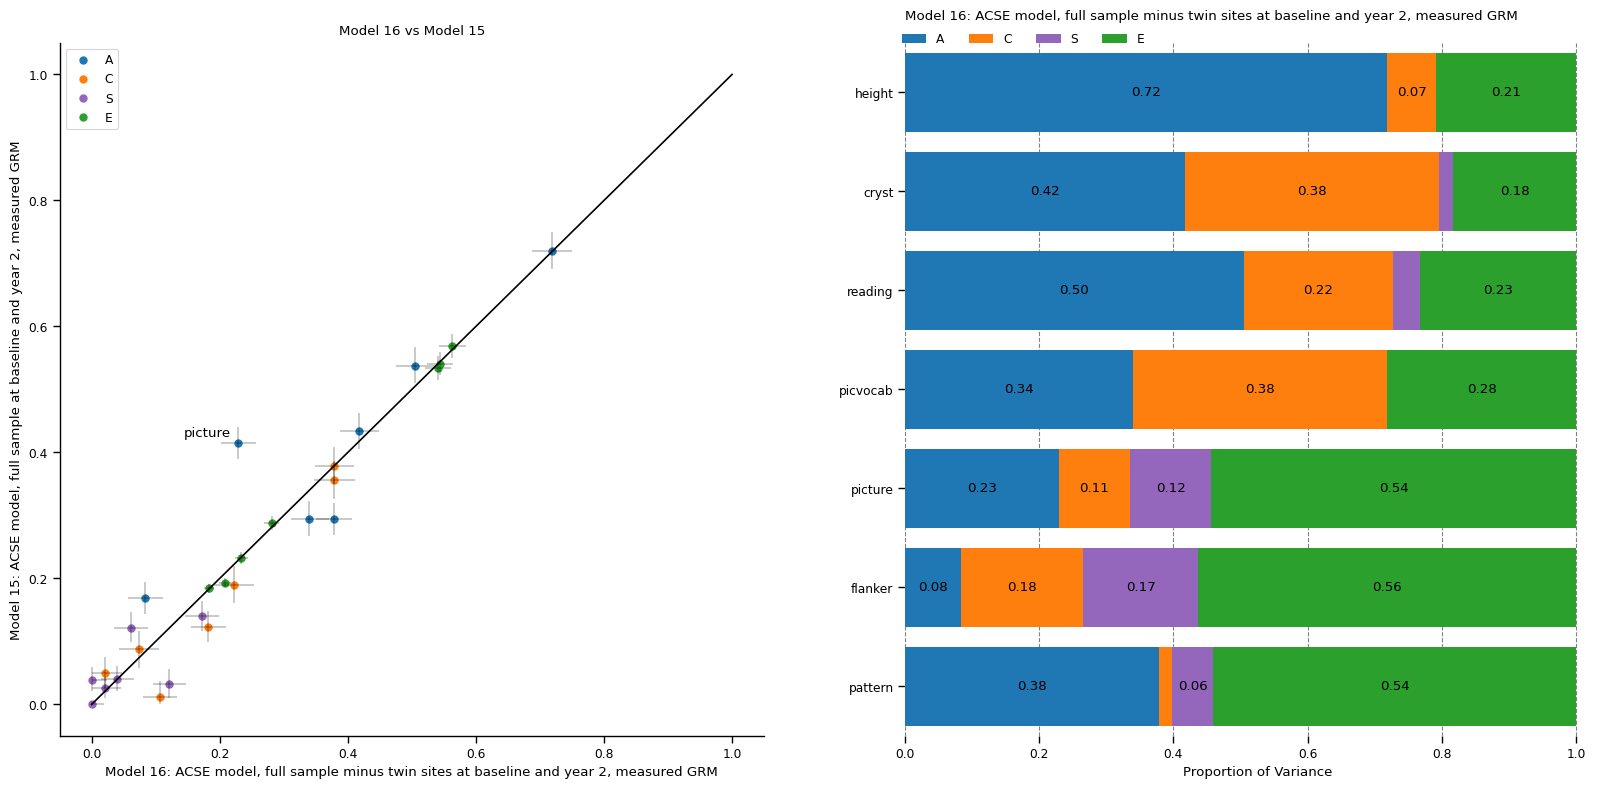

In [68]:
# compare_models("model5", "model4", sig2mat, models)

# stacked_bar("model5", sig2mat, models)

# Setting up the plot surface
fig = plt.figure(figsize=(20,9))
gs = GridSpec(nrows=1, ncols=2)

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("s3_notwins", "s3_notwins_comparison", sig2mat, models, ax=ax0, lbl = .1)

# skipping AIC because samples are different

# Right axes
ax2=fig.add_subplot(gs[0, 1])
stacked_bar("s3_notwins", sig2mat, models, ax=ax2)

In [29]:
[df[df['param']=='A'] for df in sig2mat]

for i in range(len(sig2mat)):
    print(models['shortname'][i])
#     print(sig2mat[i][sig2mat[i]['param']=='A'])



model1
model2
model3
model4
model5
model6
s1_assigngrm_m3
s1_assigngrm_m4
s1_assigngrm_m5
s2_allcovs_m1
s2_allcovs_m2
s2_allcovs_m3
s2_allcovs_m4
s2_allcovs_m5
s3_notwins_comparison
s3_notwins
test_y2
test_y2_allcovs
openmx


## Unused Code    

In [30]:
# old -- loading list of phenotypes (although this does automatically get the right order)

# baseline_phenofile = '/space/syn50/1/data/ABCD/d9smith/random_effects/behavioral/data/pheno/baseline_phenonames.txt'
# y2_phenofile = '/space/syn50/1/data/ABCD/d9smith/random_effects/behavioral/data/pheno/longitudinal_phenonames.txt'
# baseline_phenos = pd.read_csv(baseline_phenofile)
# y2_phenos = pd.read_csv(y2_phenofile)


In [31]:
# compare_models("model1", "openmx", sig2mat, models)
# fig = plt.figure()
# stacked_bar("model1", sig2mat, models)
# fig = plt.figure()
# plot_aic("model1", "openmx", model, models, baseline_phenos)


In [32]:
# # function to compile multipaneled figure
# def figure_panels(name1, name2, aic=False):
# #     """
# #     Compile multipaneled figure with model comparison, delta AIC plot (optional), and model estimates
    
# #     arguments:
# #     name1          :    string with title of model to plot on x axis
# #     name2          :    string with title of model to plot on y axis
# #     aic          :    bool indicating whether to plot aic difference
    
# #     """

In [33]:
# fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [1, 4]}, figsize=(7,6))

# # ax1.plot(x, y)
# # ax2.plot(x + 1, -y)

# # ax1=fig.add_subplot(0,0,0)
# plot_aic("model1", "openmx", model, models, baseline_phenos, ax=ax1)

# # Right axes
# # ax2=fig.add_subplot(0,0,1)
# stacked_bar("model1", sig2mat, models, ax=ax2)


# fig.tight_layout()

In [34]:
# # Setting up the plot surface
# fig = plt.figure(figsize=(10,10))
# gs = GridSpec(nrows=2, ncols=2, width_ratios = [2,8], height_ratios = [5,5])

# # Left axes
# ax0 = fig.add_subplot(gs[0, :])
# compare_models("model1", "openmx", sig2mat, models, ax=ax0, lbl = 0.05)

# # Middle axes
# ax1=fig.add_subplot(gs[1,0])
# plot_aic("model1", "openmx", model, models, baseline_phenos)

# # Right axes
# ax2=fig.add_subplot(gs[1, 1], sharey=ax1)
# stacked_bar("model1", sig2mat, models, ax=ax2)

# plt.tight_layout()
